In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

#other libraries
# from tqdm import tqdm
# import time
# import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split
import wandb

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import seaborn as sns

In [2]:
# Importerer spaleron og micro svarte hull data

module_path = str(Path.cwd().parents[0].parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *
import trainers
import lossFunctions

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "bh" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "sph" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

Running on the GPU


c:\Users\student\Desktop\Daniel og Sayna\Bachelor\Code\src\trainers.py:168: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if config.optimizer is 'adam':


In [3]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
print(bhArray.shape)
print(sphArray.shape)

(15000, 50, 50, 3)
(15000, 50, 50, 3)


In [5]:
# Vi slår sammen dataene for å ha et samlet datasett som kjører gjennom modellen
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
# 75% av datasettet havner i trainData, 25% havner i testData, 
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [9]:
# gjør det om til en tensor fra numpy array. Vi gjør dette for at at dataene skal være lagret på GPU en istedet for en liste som er lagret på CPUen 
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [10]:
# to tensor datasett 
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [11]:
# Her kommer modellen inn XD 
class ConvModel(nn.Module):
    def __init__(self, dropout):

        super(ConvModel, self).__init__()
        # 2 cov lag blir opprette. Bildene har x, y og z verdi. 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(3*3*256, 128)
        self.fc2 = nn.Linear(128,2)

        self.dropout = nn.Dropout(dropout)



    def forward(self, x:Tensor):
        x = self.conv1(x)
        x = F.relu(x) #to activate function above

        x = F.max_pool2d(x,2)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x,2)

        x = self.conv3(x)
        x = F.relu(x)

        x = F.max_pool2d(x,3)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
 
        return x

In [12]:
from torchvision import models
from torchsummary import summary

model = ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


In [13]:
config = {
    'loss': 'customLoss',
    'epoch': 5,
    'batch_size': 50,
    'gamma': 1,
    'learning_rate': 0.01,
    'optimizer': 'adam',
    'dropout': 0
}

# Pass the config dictionary when you initialize W&B
run = wandb.init(project="CNN_run", config=config)

model = ConvModel(config['dropout']).to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 591291 (g13hvl2023). Use `wandb login --relogin` to force relogin


In [14]:
model, y_pred, y_true = trainers.run(model, train, test, config)

[Text(0, 0.5, 'Mikroskopiske svarte hull'), Text(0, 1.5, 'Sphaleroner')]

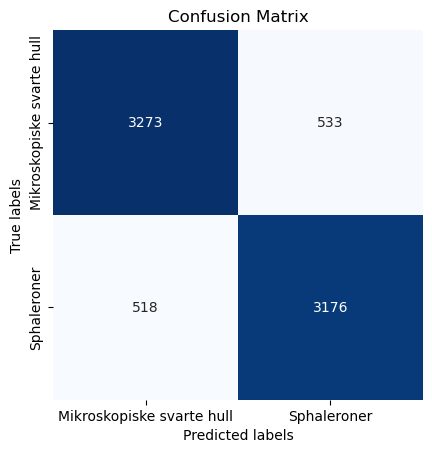

In [15]:
matrix_confusion = confusion_matrix([x.data.cpu().numpy() for x in y_pred], [x.data.cpu().numpy() for x in y_true])
ax= plt.subplot()
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Mikroskopiske svarte hull', 'Sphaleroner'])
ax.yaxis.set_ticklabels(['Mikroskopiske svarte hull', 'Sphaleroner'])

In [16]:
#Eksempel på hva model gir som output mot labels
testLoader = DataLoader(test, shuffle=True, batch_size=config['batch_size'])
a = next(iter(testLoader))  
output = model(a[0].permute(0,3,1,2).to(device))

for i in range(10):
    print("output: ", output[i].data.cpu().numpy(),"labels: ", a[1][i].data.cpu().numpy())


output:  [ 2.2548413 -2.2119074] labels:  0.0
output:  [ 0.10525537 -0.03198421] labels:  0.0
output:  [-1.6795475   0.25460386] labels:  1.0
output:  [-1.772572   1.5081016] labels:  1.0
output:  [-1.4815702  1.563778 ] labels:  1.0
output:  [ 2.291428  -2.2682562] labels:  0.0
output:  [-1.188864   1.3056324] labels:  1.0
output:  [-0.52653587  0.6171868 ] labels:  1.0
output:  [ 4.926676  -6.8212824] labels:  0.0
output:  [ 1.9329555 -1.8781198] labels:  0.0


In [17]:
#Eksempel på hva model gir som output mot labels
testLoader = DataLoader(test, shuffle=True, batch_size=config['batch_size'])
a = next(iter(testLoader))
output = model(a[0].permute(0,3,1,2).to(device))

list = torch.max(output.to(device), 1)[1] #Snakket om 16.03.2023, gir pred output

for i in range(10):
    print("output: ", list[i].data.cpu().numpy(),"labels: ", a[1][i].data.cpu().numpy())




output:  1 labels:  0.0
output:  1 labels:  1.0
output:  0 labels:  0.0
output:  1 labels:  1.0
output:  1 labels:  1.0
output:  0 labels:  0.0
output:  1 labels:  1.0
output:  1 labels:  1.0
output:  1 labels:  1.0
output:  1 labels:  1.0


In [18]:
#check loss

zeroOne = lossFunctions.ZeroOneLoss()
cross = lossFunctions.CrossEntropyLoss()

critertion = nn.CrossEntropyLoss()


print(critertion(output, a[1].long().to(device)))
print(cross(output, a[1].long().to(device)))
print(zeroOne(output, a[1].long()))

tensor(0.2476, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8600, requires_grad=True)
